Mean Squared Error: 1026.1241909000453


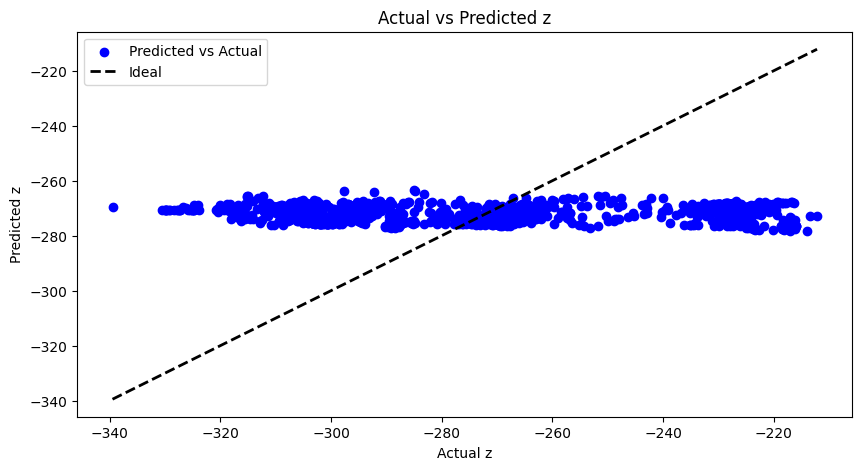

In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


# Define the function to extract data from text files and create DataFrames for each tool
def extract_data(filepath):
    data = {"Reference": [], "Fenestrated": [], "Curved": [], "Camera": []}
    with open(filepath, "r") as file:
        lines = file.readlines()
        # Store time in milliseconds
        time = int(lines[0].split()[2])
        for line in lines[1:]:  # Skip the header
            parts = line.strip().split()
            if len(parts) == 8:
                label = parts[0]
                x, y, z = float(parts[1]), float(parts[2]), float(parts[3])
                qx, qy, qz, qw = (
                    float(parts[4]),
                    float(parts[5]),
                    float(parts[6]),
                    float(parts[7]),
                )
                data[label].append(
                    {
                        "x": x,
                        "y": y,
                        "z": z,
                        "qx": qx,
                        "qy": qy,
                        "qz": qz,
                        "qw": qw,
                    }
                )
    return data


# Load data from the specified directory
data_dir = "data/6DOF/Test 5"
all_data = {"Reference": [], "Fenestrated": [], "Curved": [], "Camera": []}

for filename in os.listdir(data_dir):
    if filename.endswith(".txt"):
        file_data = extract_data(os.path.join(data_dir, filename))
        for key in all_data:
            all_data[key].extend(file_data[key])

# Convert data to DataFrames
df_fenestrated = pd.DataFrame(all_data["Fenestrated"])
df_curved = pd.DataFrame(all_data["Curved"])
df_reference = pd.DataFrame(all_data["Reference"])
df_camera = pd.DataFrame(all_data["Camera"])

# Combine fenestrated and curved data for regression
df_combined = pd.concat([df_fenestrated, df_curved], ignore_index=True)

# Features are x and y, target is z
X = df_combined[["x", "y"]]
y = df_combined["z"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train the regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, color="blue", label="Predicted vs Actual")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "k--",
    lw=2,
    label="Ideal",
)
plt.xlabel("Actual z")
plt.ylabel("Predicted z")
plt.title("Actual vs Predicted z")
plt.legend()
plt.show()